# Code for interacting with API of openFDA

## Plan
In this project, we are looking for device adverse events. We are particularly interested in:
    - Cause of failure
    - Date of failure (ie age of device)
We want to see which is the most common cause for given device to fail and at which stage of use this occurs.
Relevant fields could be (for full reference see https://open.fda.gov/device/event/reference/):
### Event
device_date_of_manufacturer
date_of_event, date_report, date_received
previous_use_code, remedial_action
single_use_flag
### Source
reprocessed_and_reused_flag
### Device
device.generic_name
device.expiration_date_of_device, device.device_age_text
device.implant_flag, device.date_removed_flag
device.manufacturer_d_name, device.manufacturer_d_state, device.manufacturer_d_country
### Patient
patient.sequence_number_outcome, patient.sequence_number_treatment
### Report Text
mdr_text.text, mdr_text.text_type_code
### Reporter Dependent Fields
#### By user facility / importer
report_date
event_location
manufacturer_name, manufacturer_country
manufacturer_g1_name, manufacturer_g1_state
### OpenFDA fields
device_class
### Further interesting fields:
Source: reporter_occupation_code
Device: device.device_operator

In [2]:
# Import modules
import numpy as np
import pandas as pd
import json
import requests
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
import sys
from time import time

In [100]:
# Build base query
baseurl = 'https://api.fda.gov/device/event.json?'

start_date = '20150324'
end_date = '20170324'
query = 'search='
limit = 50

apikey = ''
with open('apikey.txt', 'r') as myfile:
    apikey = myfile.read().replace('\n', '')

In [101]:
# features to check for existence
list_features = ['device_date_of_manufacturer', 
                 'date_of_event',
                 #'date_report',
                 #'date_received',
                 'previous_use_code',
                 #'remedial_action',
                 'single_use_flag',
                 'reprocessed_and_reused_flag',
                 #'reporter_occupation_code',
                 #'device.date_received',
                 #'device.generic_name' # this allows for empty string! 
                ]

# possibility to further narrow donw the search
# list_features_specific = ['device.openfda.device_name:"sensor"', 
#                   #'device.implant_flag:"Y"',
#                   #'previous_use_code:"I"', # I - initial use, R - reuse, U - unknown, * - invalid data
#                   #'device.manufacturer_d_country:"US"' # SZ - Switzerland
#                  ]

# list of usable device names
list_device_names = ["pump",
                    "sensor",
                    "prosthesis",
                    "defibrilator",
                    "pacemaker",
                    "catheter",
                    "electrode",
                    #"wearable",
                     "stent",
                     "ray",
                     "ventilator",
                     "bed",
                     "implant",
                     "lens",
                     #"mds" # https://www.cancer.org/cancer/myelodysplastic-syndrome/about/what-is-mds.html
                     "dialysis",
                     "graft",
                    ]
                  

In [102]:
## Build full query
# adding date range
query = query+"date_of_event:[\""+start_date+"\""+"+TO+"+"\""+end_date+"\"]"

# checking features for existence
for x in list_features:
    query = query + "+AND+_exists_:" + x

# # Possibility to furhter narrow down the search
# for y in list_features_specific:
#     query = query + "+AND+" + y

# Search for specific device, see the list abvoe
device_name = list_device_names[7]
name_query = '+AND+device.openfda.device_name:' + device_name ;

# Construct final query
# q1 = baseurl + 'api_key=' + apikey + '&' + query + '&' + 'limit=' + str(limit)
q2 = baseurl + 'api_key=' + apikey + '&' + query + name_query + '&' +'limit=' + str(limit)

In [103]:
dq = requests.get(q2)
# dq1.json()['results']
data = json.loads(dq.text)
number = data['meta']['results']['total'] # check number of matching entries
results = data['results']
number

14288

In [11]:
# Can also spare some structuring effort when loading data by calling normalization method
# dftest = pd.io.json.json_normalize(results)

In [12]:
# check that you obtained what you expected
results[3]

{'adverse_event_flag': 'N',
 'date_manufacturer_received': '20150326',
 'date_of_event': '20150326',
 'date_received': '20150406',
 'date_report': '20150326',
 'device': [{'brand_name': 'XACT CAROTID STENT SYSTEM',
   'catalog_number': '82097-01',
   'date_received': '20150406',
   'date_removed_flag': '',
   'device_age_text': '',
   'device_availability': 'No',
   'device_evaluated_by_manufacturer': 'R',
   'device_event_key': '',
   'device_operator': 'HEALTH PROFESSIONAL',
   'device_report_product_code': 'NIM',
   'device_sequence_number': ' 1.0',
   'generic_name': 'CAROTID STENT SYSTEM',
   'implant_flag': '',
   'lot_number': '4101061',
   'manufacturer_d_address_1': 'ABBOTT VASCULAR',
   'manufacturer_d_address_2': '26531 YNEZ ROAD',
   'manufacturer_d_city': 'TEMECULA',
   'manufacturer_d_country': 'US',
   'manufacturer_d_name': 'AV-TEMECULA-CT',
   'manufacturer_d_postal_code': '92591 4628',
   'manufacturer_d_state': 'CA',
   'manufacturer_d_zip_code': '92591',
   'manufac

In [104]:
# Fields of Interest
fois_result = ['device_date_of_manufacturer',
               'date_of_event']
fois_device = [#'generic_name', 
               'expiration_date_of_device', 
               #'device_age_text', 
               #'implant_flag', 
               #'date_removed_flag', \
               'manufacturer_d_name', 
               #'manufacturer_d_state',
               #'manufacturer_d_country'
              ]
fois_patient = [#'sequence_number_outcome',
                #'sequence_number_treatment'
              ]
fois_mdrText = ['text',
                'text_type_code']
fois_openfda = ['device_name',
                #'device_class',
                'medical_specialty_description']

# device = data['results'][0]['device'][0]
device = [x['device'][0] for x in data['results']]
# patient = data['results'][0]['patient'][0]
patient = [x['patient'][0] for x in data['results']]
# mdrText = data['results'][0]['mdr_text'][0] # there may be more items in the list! 
mdrText = [x['mdr_text'] for x in data['results']]
#mdrText = [y['text'] for y in [x['mdr_text'][0] for x in data['results']]]
# openfda = data['results'][0]['device'][0]['openfda']
openfda = [x['device'][0]['openfda'] for x in data['results']]

In [105]:
# Create sub dataframes for non-multiple columns
df_results = pd.DataFrame(results, index = range(len(results)), columns = fois_result)
df_openfda = pd.DataFrame(openfda, index = range(len(results)),columns = fois_openfda)
df_device = pd.DataFrame(device, index = range(len(results)),columns = fois_device)
df_patient = pd.DataFrame(patient, index = range(len(results)),columns = fois_patient)
# df_mdrText = pd.DataFrame(mdrText, index = range(len(results)),columns = fois_mdrText)

# df = pd.concat([df_device, df_patient, df_mdrText, df_openfda], axis = 1)

In [106]:
# Pull out all relevant text fields
fillDic = {'mdr_text_key': '', 'patient_sequence_number': '', 'text': np.nan, 'text_type_code': np.nan}
a = [x[0] if len(x) > 0 else fillDic for x in mdrText]
b = [x[1] if len(x) > 1 else fillDic for x in mdrText]
c = [x[2] if len(x) > 2 else fillDic for x in mdrText] 


a = pd.DataFrame(a, index = range(len(results)),columns = fois_mdrText)
b = pd.DataFrame(b, index = range(len(results)),columns = fois_mdrText)
c = pd.DataFrame(c, index = range(len(results)),columns = fois_mdrText)

In [107]:
# Rename duplicate columns:
fois_mdrText_a = [x + '_0' for x in fois_mdrText]
fois_mdrText_b = [x + '_1' for x in fois_mdrText]
fois_mdrText_c = [x + '_2' for x in fois_mdrText]

columns_a = dict(zip(fois_mdrText, fois_mdrText_a))
columns_b = dict(zip(fois_mdrText, fois_mdrText_b))
columns_c = dict(zip(fois_mdrText, fois_mdrText_c))

a.rename(columns = columns_a, inplace = True)
b.rename(columns = columns_b, inplace = True)
c.rename(columns = columns_c, inplace = True)

# I haven't seen a four-field entry. If there were some, we would need to deal with them in smarter way

In [108]:
# Construct final data frame
df_mdrText = pd.concat([a, b, c], axis = 1)

# Concatenate into final dataframe
df = pd.concat([df_results, df_device, df_patient, df_mdrText, df_openfda], axis = 1)

In [109]:
# Determine age of device in days
df['age_of_device_days'] = pd.to_datetime(df['date_of_event'], format='%Y%m%d') \
- pd.to_datetime(df['device_date_of_manufacturer'], format='%Y%m%d')


# Determine timedelta from failure to specified expiry date
df['days_to_expiry'] = pd.to_datetime(df['expiration_date_of_device'], format='%Y%m%d') \
- pd.to_datetime(df['device_date_of_manufacturer'], format='%Y%m%d')
df = df.drop(['date_of_event','device_date_of_manufacturer', 'expiration_date_of_device'], axis = 1)

In [110]:
df

,manufacturer_d_name,text_0,text_type_code_0,text_1,text_type_code_1,text_2,text_type_code_2,device_name,medical_specialty_description,age_of_device_days,days_to_expiry
0,MEDTRONIC IRELAND,RESULTS: RELATED TO OPERATIONAL CONTEXT (THE 3...,Additional Manufacturer Narrative,IT IS REPORTED THAT THE PATIENT HAD A STENT PR...,Description of Event or Problem,EVALUATION RESULTS: (CINE IMAGES WERE UNABLE T...,Additional Manufacturer Narrative,Coronary Drug-Eluting Stent,Unknown,250 days,548 days
1,BOSTON SCIENTIFIC - GALWAY,"SAME CASE AS MDR ID: 2134265-2015-02289, 21342...",Description of Event or Problem,DATE OF BIRTH: 1975. (B)(6). DEVICE IS A COMBI...,Additional Manufacturer Narrative,NaN,NaN,Coronary Drug-Eluting Stent,Unknown,187 days,498 days
2,BOSTON SCIENTIFIC - GALWAY,DATE OF BIRTH: 1975. (B)(6). DEVICE IS A COMBI...,Additional Manufacturer Narrative,"SAME CASE AS MDR ID: 2134265-2015-02270, 21342...",Description of Event or Problem,NaN,NaN,Coronary Drug-Eluting Stent,Unknown,211 days,495 days
3,AV-TEMECULA-CT,IT WAS REPORTED THAT DURING A PROCEDURE TO TRE...,Description of Event or Problem,(B)(4). IT IS INDICATED THAT THE DEVICE IS NOT...,Additional Manufacturer Narrative,NaN,NaN,"Stent, Carotid",Unknown,176 days,NaT
4,AV-TEMECULA-CT,(B)(4). THERE WAS NO REPORTED DEVICE MALFUNCTI...,Additional Manufacturer Narrative,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,Description of Event or Problem,NaN,NaN,Coronary Drug-Eluting Stent,Unknown,207 days,NaT
5,AV-TEMECULA-CT,(B)(4). THERE WAS NO REPORTED DEVICE MALFUNCTI...,Additional Manufacturer Narrative,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,Description of Event or Problem,NaN,NaN,Coronary Drug-Eluting Stent,Unknown,147 days,NaT
6,AV-TEMECULA-CT,(B)(4). CONCOMITANT PRODUCTS: GUIDE WIRE: SION...,Additional Manufacturer Narrative,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,Description of Event or Problem,NaN,NaN,Coronary Drug-Eluting Stent,Unknown,181 days,737 days
7,BOSTON SCIENTIFIC - GALWAY,SAME CASE AS MDR ID: 2134265-2015-02007 AND 21...,Description of Event or Problem,DEVICE IS A COMBINATION PRODUCT. THE COMPLAINT...,Additional Manufacturer Narrative,EVENT DATE CORRECTED FROM (B)(6) 2015. (B)(4).,Additional Manufacturer Narrative,Coronary Drug-Eluting Stent,Unknown,483 days,308 days
8,BOSTON SCIENTIFIC - MAPLE GROVE,DEVICE IS A COMBINATION PRODUCT. THE COMPLAINT...,Additional Manufacturer Narrative,SAME CASE AS MDR ID: 2134265-2015-02008 AND 21...,Description of Event or Problem,"IT WAS FURTHER REPORTED THAT IN (B)(6) 2015, T...",Description of Event or Problem,Coronary Drug-Eluting Stent,Unknown,1172 days,308 days
9,ATRIUM MEDICAL CORP.,WE ARE AWAITING THE RETURN OF THE DEVICE FOR I...,Additional Manufacturer Narrative,STENT DISLODGED FROM BALLOON UPON ACCESS THROU...,Description of Event or Problem,NaN,NaN,"Stent, Renal",Unknown,116 days,NaT


In [13]:
# Write to file for manual inspection

# file_name = device_name + '_mdrTextClasses.csv'
# # cols_to_write = ['text', 'text_type_code', 'device_name',
# #        'medical_specialty_description', 'age_of_device_days']
# df.to_csv(file_name, mode = 'w', encoding='utf-8')

### Factorize selected columns
This will convert nominal (string) entries into categorical.

In [111]:
# Columns that we want to translate into categories
factCols = ['manufacturer_d_name',
        'text_type_code_0',
        'text_type_code_1', 
        'text_type_code_2',
        'device_name', 'medical_specialty_description']

# This also works but will not assign consistent labeling across multiple columns
df[factCols] = df[factCols].apply(lambda x: pd.factorize(x)[0])

In [14]:
# # http://stackoverflow.com/questions/39390160/pandas-factorize-on-an-entire-data-frame
# def categorise(df):
#     categories = {k: v for v, k in enumerate(df.stack().unique())}
#     return df.replace(categories)
# df[factCols] = categorise(df[factCols])

In [112]:
# http://stackoverflow.com/questions/28910851/python-pandas-changing-some-column-types-to-categories
# http://pandas.pydata.org/pandas-docs/stable/categorical.html

# df[factCols2].astype('category')
df[factCols] = df[factCols].apply(lambda x: x.astype('category'))

Later we may want to adress the issue of rather random (although consistent) numbering of categories. Both are not currently crucial.

In [113]:
df

,manufacturer_d_name,text_0,text_type_code_0,text_1,text_type_code_1,text_2,text_type_code_2,device_name,medical_specialty_description,age_of_device_days,days_to_expiry
0,0,RESULTS: RELATED TO OPERATIONAL CONTEXT (THE 3...,0,IT IS REPORTED THAT THE PATIENT HAD A STENT PR...,0,EVALUATION RESULTS: (CINE IMAGES WERE UNABLE T...,0,0,0,250 days,548 days
1,1,"SAME CASE AS MDR ID: 2134265-2015-02289, 21342...",1,DATE OF BIRTH: 1975. (B)(6). DEVICE IS A COMBI...,1,NaN,-1,0,0,187 days,498 days
2,1,DATE OF BIRTH: 1975. (B)(6). DEVICE IS A COMBI...,0,"SAME CASE AS MDR ID: 2134265-2015-02270, 21342...",0,NaN,-1,0,0,211 days,495 days
3,2,IT WAS REPORTED THAT DURING A PROCEDURE TO TRE...,1,(B)(4). IT IS INDICATED THAT THE DEVICE IS NOT...,1,NaN,-1,1,0,176 days,NaT
4,2,(B)(4). THERE WAS NO REPORTED DEVICE MALFUNCTI...,0,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,0,NaN,-1,0,0,207 days,NaT
5,2,(B)(4). THERE WAS NO REPORTED DEVICE MALFUNCTI...,0,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,0,NaN,-1,0,0,147 days,NaT
6,2,(B)(4). CONCOMITANT PRODUCTS: GUIDE WIRE: SION...,0,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,0,NaN,-1,0,0,181 days,737 days
7,1,SAME CASE AS MDR ID: 2134265-2015-02007 AND 21...,1,DEVICE IS A COMBINATION PRODUCT. THE COMPLAINT...,1,EVENT DATE CORRECTED FROM (B)(6) 2015. (B)(4).,0,0,0,483 days,308 days
8,3,DEVICE IS A COMBINATION PRODUCT. THE COMPLAINT...,0,SAME CASE AS MDR ID: 2134265-2015-02008 AND 21...,0,"IT WAS FURTHER REPORTED THAT IN (B)(6) 2015, T...",1,0,0,1172 days,308 days
9,4,WE ARE AWAITING THE RETURN OF THE DEVICE FOR I...,0,STENT DISLODGED FROM BALLOON UPON ACCESS THROU...,0,NaN,-1,2,0,116 days,NaT


## Try to make some sense of text data

In [114]:
# estabilish variables
lsa = 4
n_features = 10000
k = 5

# pull out relevant subset
df_text = df[df.columns[df.columns.to_series().str.contains('^text_[0-9]$')]]

In [115]:
# comvert data into singledimensional iterable [list]
IDXS = df_text.index
COLS = df_text.columns

df_text_cat = df_text.apply(lambda x: '; '.join(x.dropna().values.tolist()), axis=1)
text_np_cat = df_text_cat.values


# text_np = df_text.values
# text_np_cat = ['; '.join(map(str, x)) for x in text_np]

#### Do Tfidf vectorization

In [116]:
# Do Tfidf vectorization
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(text_np_cat)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

done in 0.024001s
n_samples: 50, n_features: 515



#### Do clustering

In [117]:
#clustering
km = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=False)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))


Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=False)
done in 0.068s


In [118]:
# See the cluster assignements
uniqs, uniq_counts = np.unique(km.labels_, return_counts = True)
dict(zip(uniqs,uniq_counts))

{0: 6, 1: 8, 2: 17, 3: 5, 4: 14}

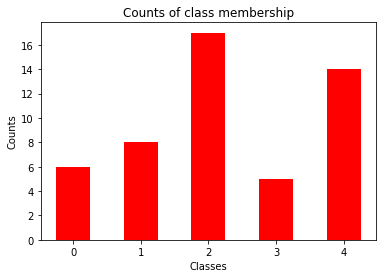

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
width = 0.5       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(uniqs, uniq_counts, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_xlabel('Classes')
ax.set_title('Counts of class membership')
ax.set_xticks(uniqs)
plt.show()

In [142]:
df_text[km.labels_ == 4]

,text_0,text_1,text_2
3,IT WAS REPORTED THAT DURING A PROCEDURE TO TRE...,(B)(4). IT IS INDICATED THAT THE DEVICE IS NOT...,NaN
6,(B)(4). CONCOMITANT PRODUCTS: GUIDE WIRE: SION...,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,NaN
9,WE ARE AWAITING THE RETURN OF THE DEVICE FOR I...,STENT DISLODGED FROM BALLOON UPON ACCESS THROU...,NaN
11,"(B)(4). DURING PROCESSING OF THIS COMPLAINT, A...",(B)(4). EVALUATION SUMMARY: THE DEVICE WAS RET...,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...
12,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,"(B)(4). DURING PROCESSING OF THIS COMPLAINT, A...",NaN
14,(B)(4). EVALUATION SUMMARY: THE DEVICE WAS RET...,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,(B)(4). THE DEVICE IS EXPECTED TO BE RETURNED ...
15,(B)(4). EVALUATION SUMMARY: THE DEVICE WAS RET...,"(B)(4). DURING PROCESSING OF THIS COMPLAINT, A...",IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...
16,(B)(4). IT IS INDICATED THAT THE DEVICE IS NOT...,IT WAS REPORTED THAT BEFORE USE AND WHILE PULL...,NaN
22,(B)(4). THE DEVICE WAS RECEIVED. INVESTIGATION...,IT WAS REPORTED THAT THE PROCEDURE WAS TO TREA...,(B)(4). EVALUATION SUMMARY: THE DEVICE WAS RET...
31,IT WAS REPORTED THAT DURING A COMPLEX PROCEDUR...,"(B)(4). DURING PROCESSING OF THIS COMPLAINT, A...",NaN


In [120]:
df2 = df.drop(df.columns[df.columns.to_series().str.contains('^text_*')], axis = 1)
df2['mdr_text_class'] = km.labels_
df2

,manufacturer_d_name,device_name,medical_specialty_description,age_of_device_days,days_to_expiry,mdr_text_class
0,0,0,0,250 days,548 days,0
1,1,0,0,187 days,498 days,0
2,1,0,0,211 days,495 days,0
3,2,1,0,176 days,NaT,2
4,2,0,0,207 days,NaT,2
5,2,0,0,147 days,NaT,2
6,2,0,0,181 days,737 days,2
7,1,0,0,483 days,308 days,0
8,3,0,0,1172 days,308 days,0
9,4,2,0,116 days,NaT,1


In [121]:
df2['days_to_expiry'] = df2['days_to_expiry'].dt.days

In [122]:
# X = df2[df2.columns != 'age_of_device_days'].as_matrix

X = df2.ix[:, df2.columns != 'age_of_device_days'].values
days = df2['age_of_device_days']
y = days.dt.days.values

In [99]:
print ([X,  y])

[array([[0, 0, 0, 298.0, 3],
       [1, 0, 0, 311.0, 0],
       [1, 0, 0, 284.0, 0],
       [2, 1, 0, nan, 1],
       [2, 0, 0, nan, 1],
       [2, 0, 0, nan, 1],
       [2, 0, 0, 556.0, 1],
       [1, 0, 0, -175.0, 0],
       [3, 0, 0, -864.0, 0],
       [4, 2, 0, nan, 2],
       [2, 0, 0, 449.0, 1],
       [2, 3, 0, 402.0, 2],
       [2, 0, 0, 462.0, 1],
       [1, 0, 0, 74.0, 4],
       [2, 0, 0, nan, 2],
       [2, 0, 0, nan, 2],
       [2, 4, 0, 371.0, 1],
       [2, 4, 0, 616.0, 2],
       [2, 4, 0, 555.0, 2],
       [2, 4, 0, 372.0, 2],
       [2, 4, 0, 220.0, 2],
       [2, 4, 0, 341.0, 2],
       [2, 5, 0, nan, 1],
       [1, 0, 0, 363.0, 3],
       [1, 0, 0, 350.0, 3],
       [1, 0, 0, 380.0, 3],
       [1, 0, 0, 321.0, 3],
       [1, 6, 1, 692.0, 3],
       [3, 4, 0, 60.0, 4],
       [1, 0, 0, 369.0, 4],
       [1, 0, 0, 177.0, 3],
       [2, 5, 0, 700.0, 2],
       [2, 0, 0, nan, 2],
       [2, 0, 0, nan, 1],
       [2, 0, 0, nan, 2],
       [1, 0, 0, 318.0, 3],
       [1, 